## 1) Import necessary libraries

In [66]:
# code here
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [67]:
import pandas as pd
import xml.etree.ElementTree as ET
from datetime import datetime

# Path to your XML file
file_path = 'export.xml'

# Read and parse the XML file
parser = ET.XMLParser(encoding='utf-8')
with open(file_path, 'r', encoding='utf-8') as file:
    xml_data = file.read()
    root = ET.fromstring(xml_data, parser=parser)

data = []
for record in root.findall('Record'):
    record_type = record.get('type')
    if record_type not in ["HKQuantityTypeIdentifierDistanceWalkingRunning", "HKQuantityTypeIdentifierStepCount"]:
        continue

    start_date = record.get('startDate')
    value = float(record.get('value'))
    
    # Parse the date and extract required parts
    date_obj = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S %z')
    day_of_week = date_obj.strftime('%A')
    month = date_obj.strftime('%B')
    day_of_month = date_obj.day
    year = date_obj.year

    # Initialize values for each column
    distance_walking_running = None
    step_count = None

    # Assign value to the appropriate column
    if record_type == "HKQuantityTypeIdentifierDistanceWalkingRunning":
        distance_walking_running = value
    elif record_type == "HKQuantityTypeIdentifierStepCount":
        step_count = value

    data.append([day_of_week, month, day_of_month, year, distance_walking_running, step_count])

# Create DataFrame
df = pd.DataFrame(data, columns=['Day of the Week', 'Month', 'Day of the Month', 'Year', 'DistanceWalkingRunning', 'StepCount'])

# Group by day, month, year, and day of the week and sum the values for each type
grouped_df = df.groupby(['Day of the Week', 'Day of the Month', 'Month', 'Year']).agg(
    TotalDistanceWalkingRunning=pd.NamedAgg(column='DistanceWalkingRunning', aggfunc='sum'),
    TotalStepCount=pd.NamedAgg(column='StepCount', aggfunc='sum')
).reset_index()


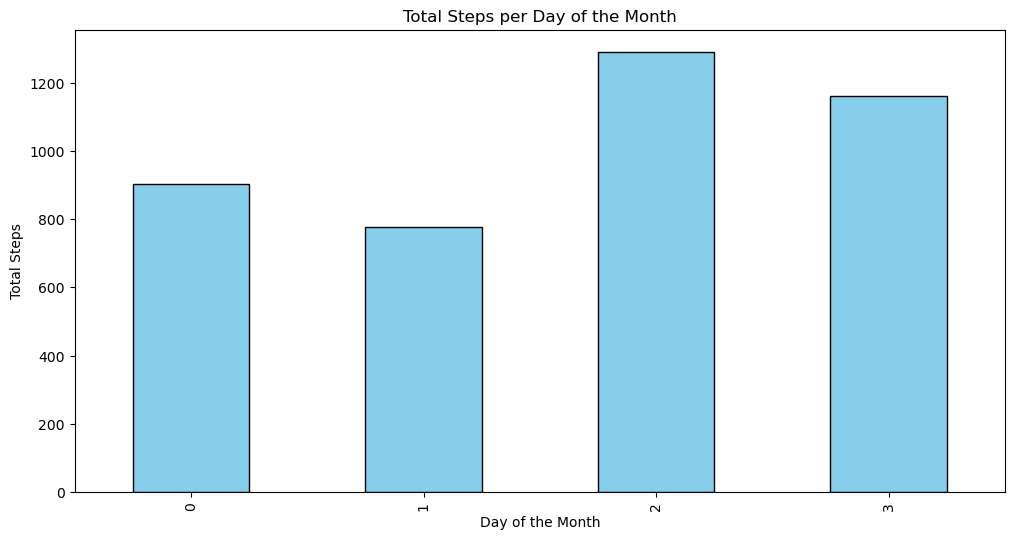

In [92]:
# Aggregate data to get total steps for each day of the month
total_steps_per_day = grouped_df.groupby('Season')['TotalStepCount'].sum()

# Create a bar plot
plt.figure(figsize=(12, 6))
total_steps_per_day.plot(kind='bar', color='skyblue', edgecolor='black')

# Adding titles and labels
plt.title('Total Steps per Day of the Month')
plt.xlabel('Day of the Month')
plt.ylabel('Total Steps')

# Show the plot
plt.show()

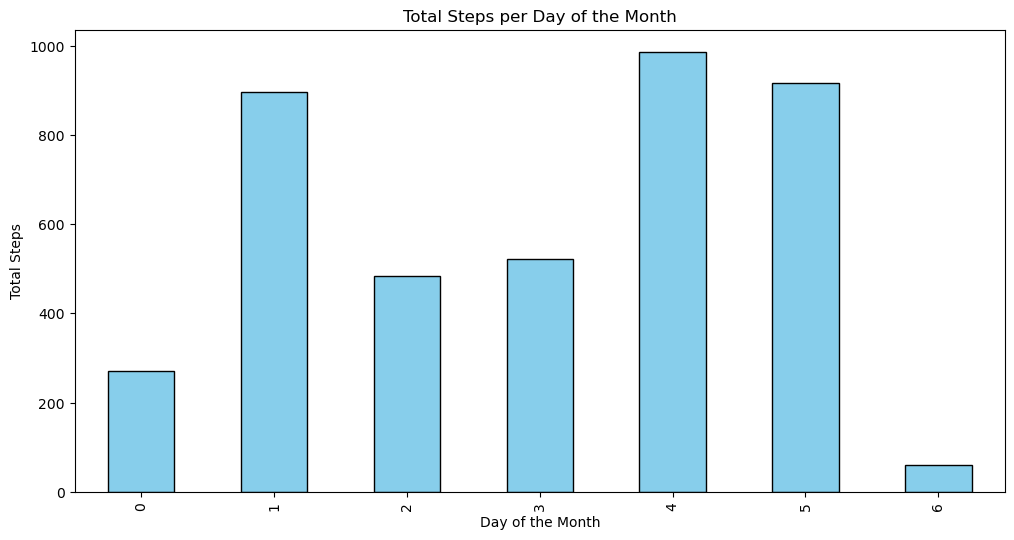

In [90]:

# Aggregate data to get total steps for each day of the month
total_steps_per_day = grouped_df.groupby('Year')['TotalStepCount'].sum()

# Create a bar plot
plt.figure(figsize=(12, 6))
total_steps_per_day.plot(kind='bar', color='skyblue', edgecolor='black')

# Adding titles and labels
plt.title('Total Steps per Day of the Month')
plt.xlabel('Day of the Month')
plt.ylabel('Total Steps')

# Show the plot
plt.show()

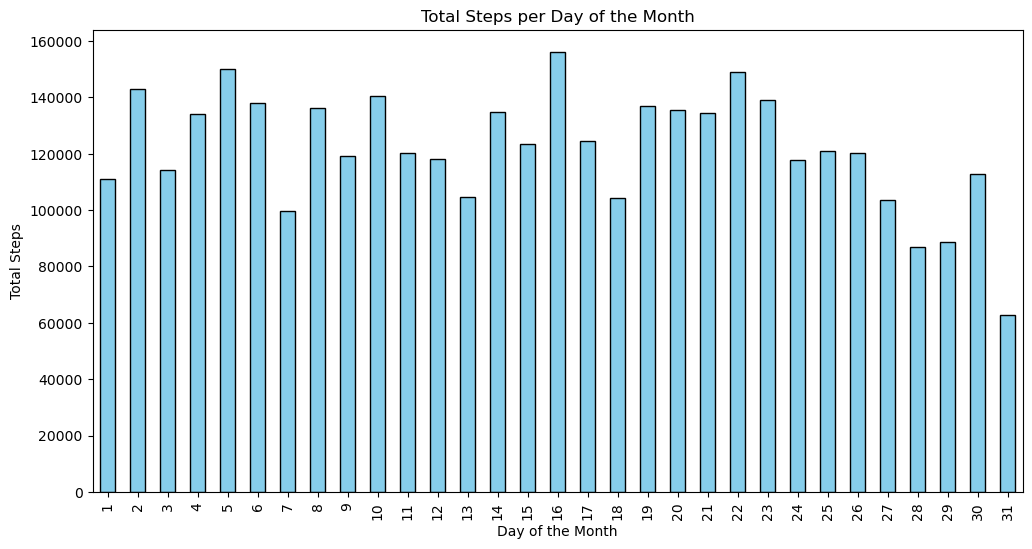

In [68]:

# Aggregate data to get total steps for each day of the month
total_steps_per_day = grouped_df.groupby('Day of the Month')['TotalStepCount'].sum()

# Create a bar plot
plt.figure(figsize=(12, 6))
total_steps_per_day.plot(kind='bar', color='skyblue', edgecolor='black')

# Adding titles and labels
plt.title('Total Steps per Day of the Month')
plt.xlabel('Day of the Month')
plt.ylabel('Total Steps')

# Show the plot
plt.show()

In [69]:
day_map = {'Sunday': 6, 'Saturday': 5, 'Friday': 4, 'Thursday': 3, 'Wednesday': 2, 'Tuesday': 1, 'Monday': 0}
month_map = {'December': 11, 'November': 10, 'October': 9, 'September': 8, 'August': 7, 'July': 6, 'June': 5, 'May': 4, 'April': 3, 'March': 2, 'February': 1, 'January': 0}
year_map = {2024: 6, 2023: 5, 2022: 4, 2021: 3, 2020: 2, 2019: 1, 2018: 0}
grouped_df['Day of the Week'] = grouped_df['Day of the Week'].map(day_map)
grouped_df['Month'] = grouped_df['Month'].map(month_map)
grouped_df['Year'] = grouped_df['Year'].map(year_map)

def map_steps(value):
    if value < 100:
        return 0
    elif 100 <= value < 1000:
        return 1  
    elif 1000 <= value < 2000:
        return 2
    elif 2000 <= value < 3000:
        return 3
    elif 3000 <= value < 4000:
        return 4
    elif 4000 <= value < 7000:
        return 5
    elif 7000 <= value < 12000:
        return 6
    elif value >= 12000:
        return 7
    

grouped_df['TotalStepCount'] = grouped_df['TotalStepCount'].apply(map_steps)


In [70]:
# Weekday/Weekend Column
grouped_df['Weekday_Weekend'] = grouped_df['Day of the Week'].apply(lambda x: 0 if x <= 4 else 1)

# Season Column
def classify_season(month):
    if month in [11, 0, 1]:  # Winter
        return 0
    elif month in [2, 3, 4]:  # Spring
        return 1
    elif month in [5, 6, 7]:  # Summer
        return 2
    elif month in [8, 9, 10]:  # Fall
        return 3

grouped_df['Season'] = grouped_df['Month'].apply(classify_season)

# Last Year Column
grouped_df['Is_Last_Year'] = grouped_df['Year'].apply(lambda x: 1 if x == 5 else 0)

In [71]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

grouped_df = grouped_df.drop('TotalDistanceWalkingRunning', axis=1)
# Shuffle the dataset
grouped_df = shuffle(grouped_df, random_state=1)

# Separating the dependent variable y and independent variables X
X = grouped_df.drop('TotalStepCount', axis=1)
y = grouped_df['TotalStepCount']

# Splitting the dataset into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

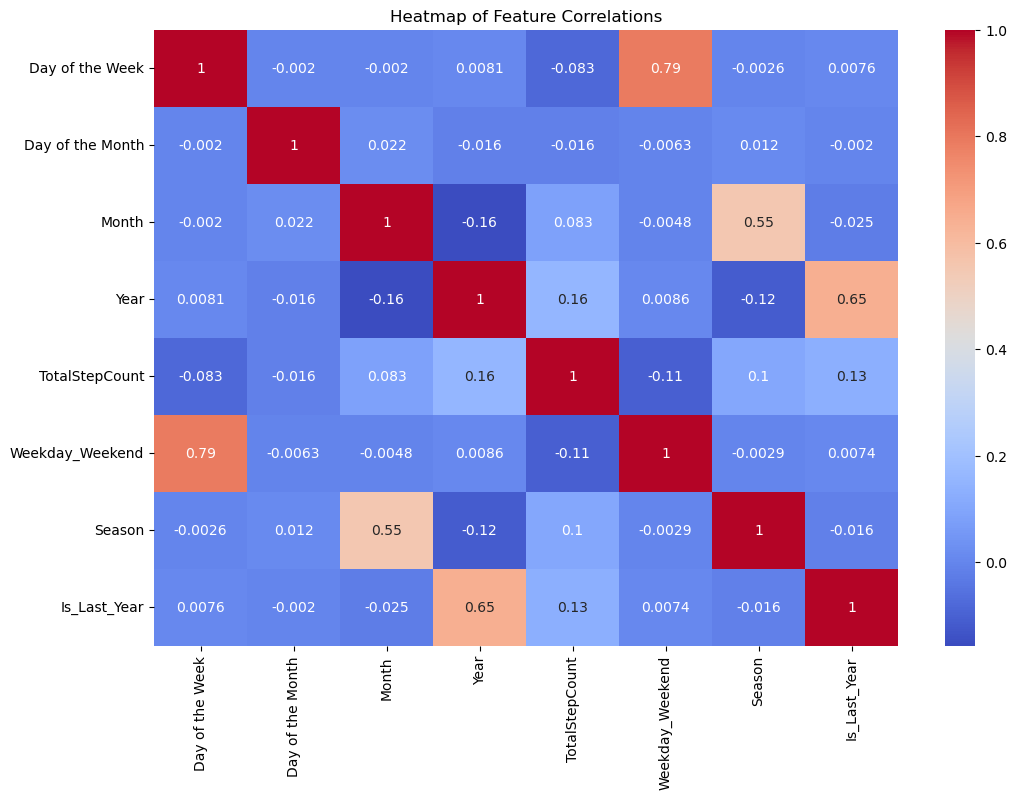

TotalStepCount      1.000000
Year                0.159090
Is_Last_Year        0.129105
Season              0.104074
Month               0.082536
Day of the Month   -0.016019
Day of the Week    -0.083172
Weekday_Weekend    -0.106140
Name: TotalStepCount, dtype: float64

In [72]:
# code here
# Calculate correlations for all features in the cleaned dataset
correlations = grouped_df.corr()

# Plotting the heatmap of correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.title('Heatmap of Feature Correlations')
plt.show()

# Displaying the correlations with the target variable 'health_metrics'
correlations_with_target = correlations['TotalStepCount'].sort_values(ascending=False)
correlations_with_target

c:\anaconda\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


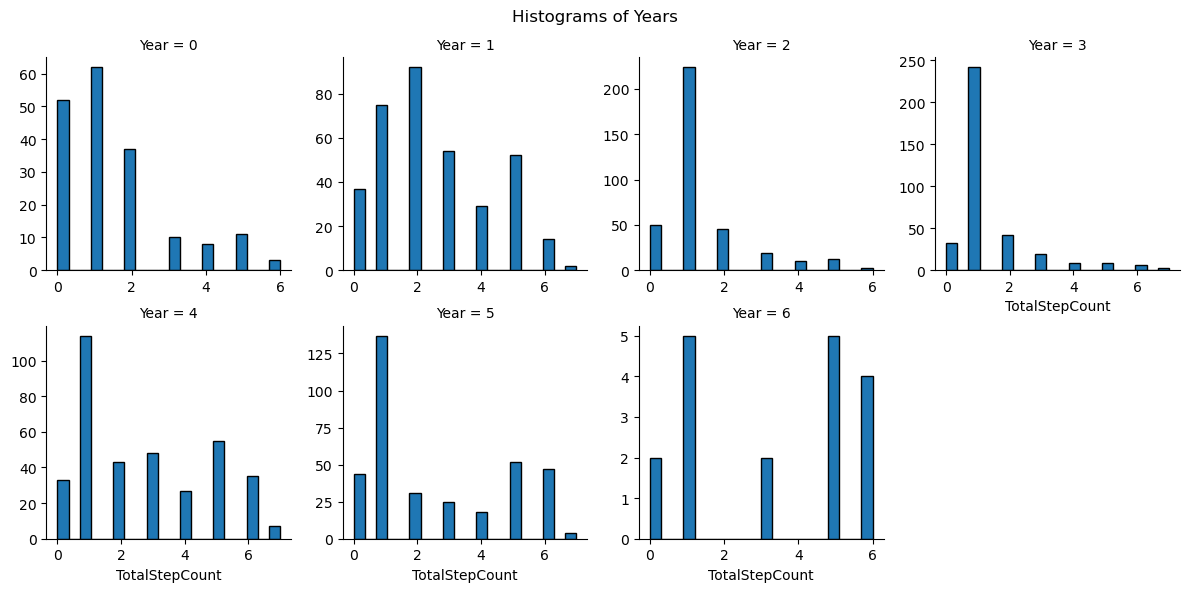

In [73]:
# Set up the FacetGrid
g = sns.FacetGrid(grouped_df, col='Year', col_wrap=4, sharex=False, sharey=False)

# Draw a histogram in each subplot
g.map(plt.hist, 'TotalStepCount', bins=20, edgecolor='k')

# Add a title and adjust layout
g.fig.suptitle('Histograms of Years')
plt.subplots_adjust(top=0.9)
plt.show()


c:\anaconda\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


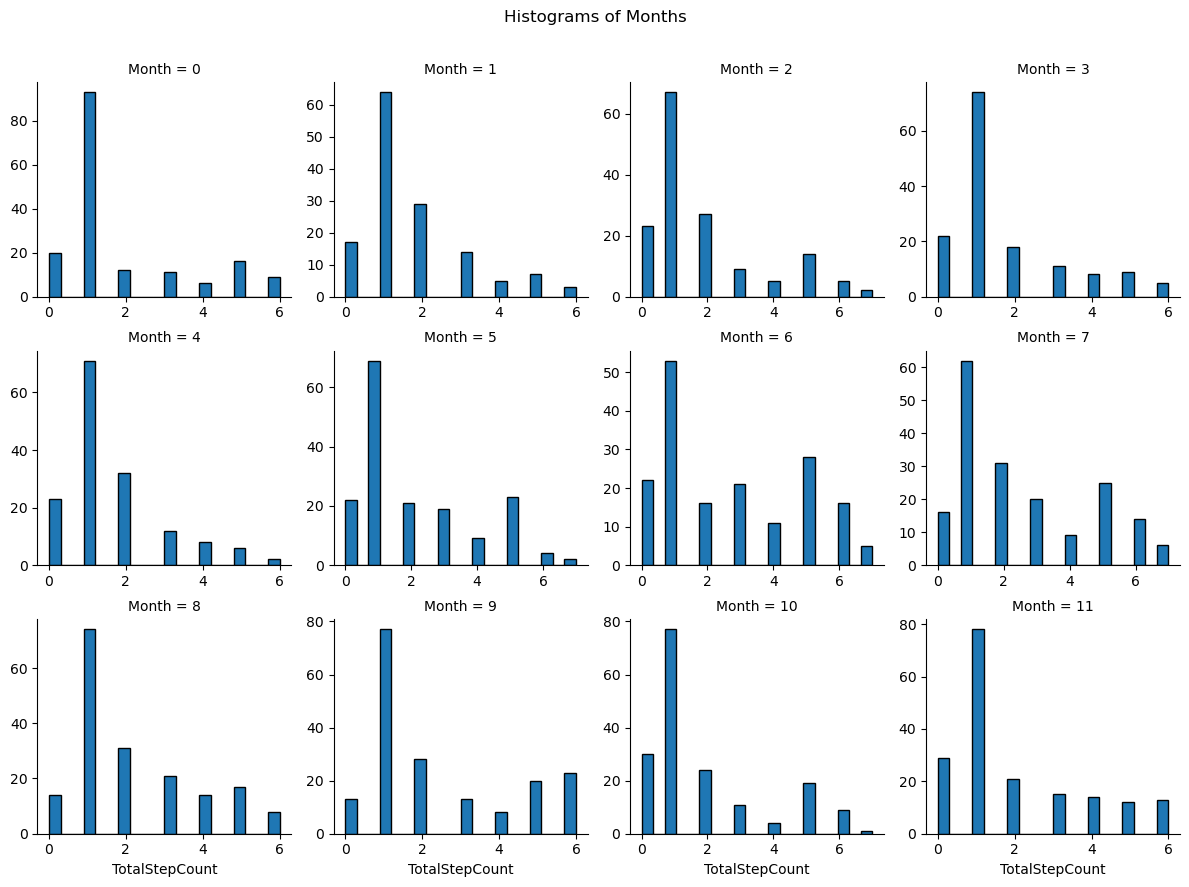

In [74]:
# Set up the FacetGrid
g = sns.FacetGrid(grouped_df, col='Month', col_wrap=4, sharex=False, sharey=False)

# Draw a histogram in each subplot
g.map(plt.hist, 'TotalStepCount', bins=20, edgecolor='k')

# Add a title and adjust layout
g.fig.suptitle('Histograms of Months')
plt.subplots_adjust(top=0.9)
plt.show()


c:\anaconda\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


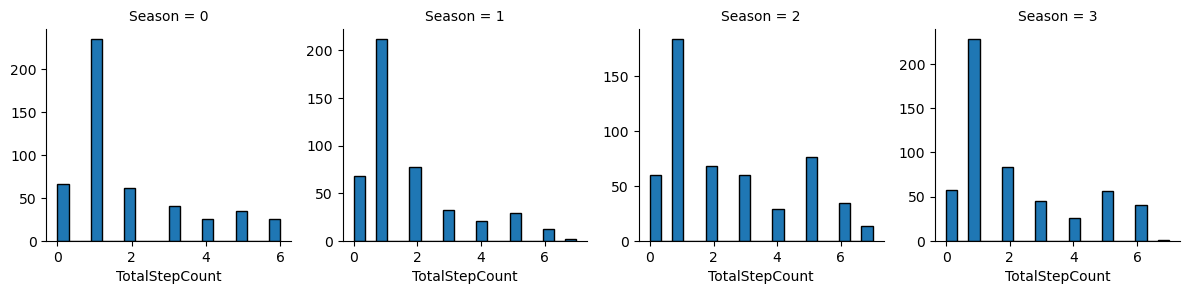

In [75]:
# Set up the FacetGrid
g = sns.FacetGrid(grouped_df, col='Season', col_wrap=4, sharex=False, sharey=False)

# Draw a histogram in each subplot
g.map(plt.hist, 'TotalStepCount', bins=20, edgecolor='k')

# Add a title and adjust layout
plt.subplots_adjust(top=0.9)
plt.show()


c:\anaconda\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


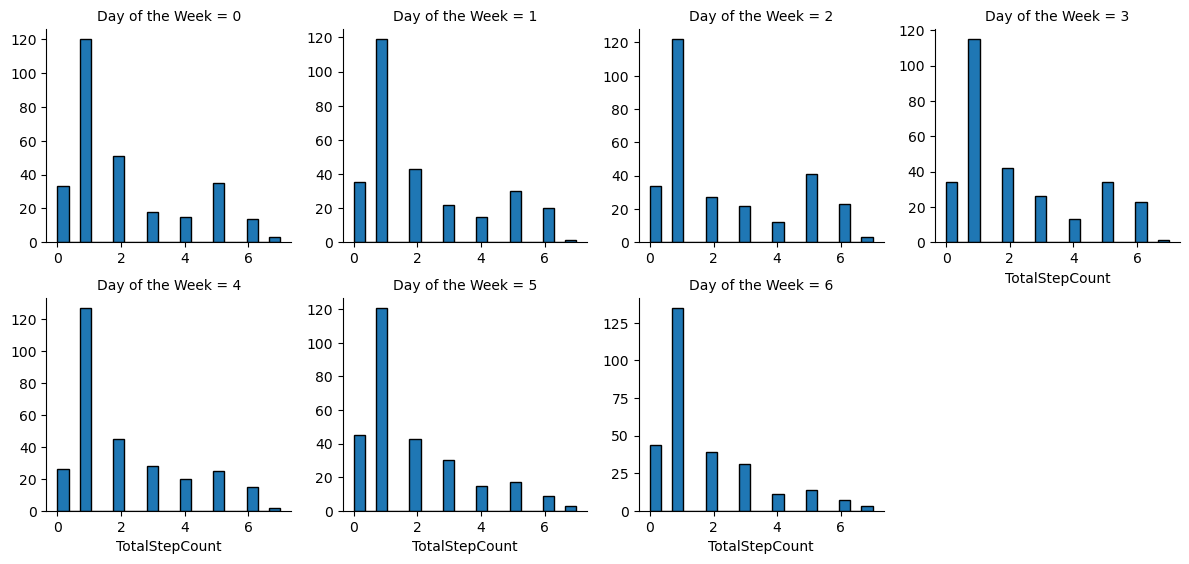

In [76]:
# Set up the FacetGrid
g = sns.FacetGrid(grouped_df, col='Day of the Week', col_wrap=4, sharex=False, sharey=False)

# Draw a histogram in each subplot
g.map(plt.hist, 'TotalStepCount', bins=20, edgecolor='k')

# Add a title and adjust layout
plt.subplots_adjust(top=0.9)
plt.show()


c:\anaconda\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


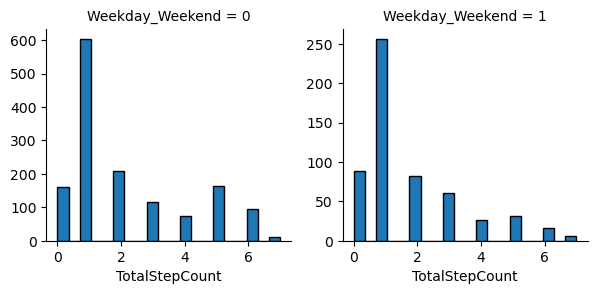

In [77]:
# Set up the FacetGrid
g = sns.FacetGrid(grouped_df, col='Weekday_Weekend', col_wrap=4, sharex=False, sharey=False)

# Draw a histogram in each subplot
g.map(plt.hist, 'TotalStepCount', bins=20, edgecolor='k')

# Add a title and adjust layout
plt.subplots_adjust(top=0.9)
plt.show()


Confusion Matrix:
[[ 17  23   0   2   1   2   0   1]
 [  7 120   8   7   3   2   4   5]
 [  3  27  14   7   6   1   3   0]
 [  2  22   5   7   3   5   3   0]
 [  4   7   4   2   2   2   1   0]
 [  3  11   2   6   4   9   6   0]
 [  1   6   0   0   0   8   8   1]
 [  0   1   0   0   1   2   0   0]]


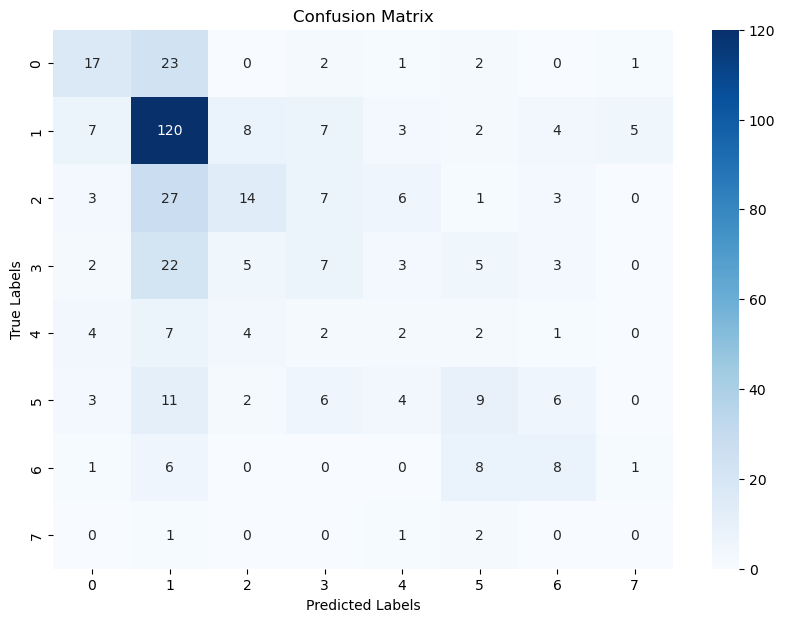

Accuracy: 0.44139650872817954, Precision: 0.4131604318009274, Recall: 0.44139650872817954, F1 Score: 0.4139820239540894
Feature Importances:
            Feature  Importance
1  Day of the Month    0.365586
2             Month    0.182960
3              Year    0.171261
0   Day of the Week    0.168932
5            Season    0.065999
4   Weekday_Weekend    0.026003
6      Is_Last_Year    0.019259


In [80]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import pandas as pd
import numpy as np

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=1)

# Determine the strategy for each class
class_counts = y_train.value_counts()
majority_class_count = class_counts.max()
sampling_strategy = {cls: int(majority_class_count * 0.4) for cls in class_counts.index if class_counts[cls] < majority_class_count}

# Create a SMOTE object with a custom strategy
smote = SMOTE(sampling_strategy=sampling_strategy, k_neighbors=1, random_state=1)

# Create a pipeline with SMOTE and RandomForest
pipeline = Pipeline([('smote', smote), ('rf', rf)])

# Define the parameter grid for RandomForest
param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [5, 10, 15, 20, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 'log2']
}

# Use TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Setup RandomizedSearchCV with the pipeline
random_search = RandomizedSearchCV(pipeline, param_grid, n_iter=10, cv=tscv, scoring='f1_weighted', n_jobs=-1, random_state=1)

# Fit the model
random_search.fit(X_train, y_train)

# Predict on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluation metrics
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print evaluation metrics
print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

# Feature importance analysis for the best model
feature_names = X_train.columns
feature_importances = best_model.named_steps['rf'].feature_importances_
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

# Display feature importances
print("Feature Importances:")
print(importance_df)


            Feature  Importance
1  Day of the Month    0.323528
3              Year    0.207863
2             Month    0.193148
0   Day of the Week    0.160556
5            Season    0.066094
4   Weekday_Weekend    0.026833
6      Is_Last_Year    0.021978


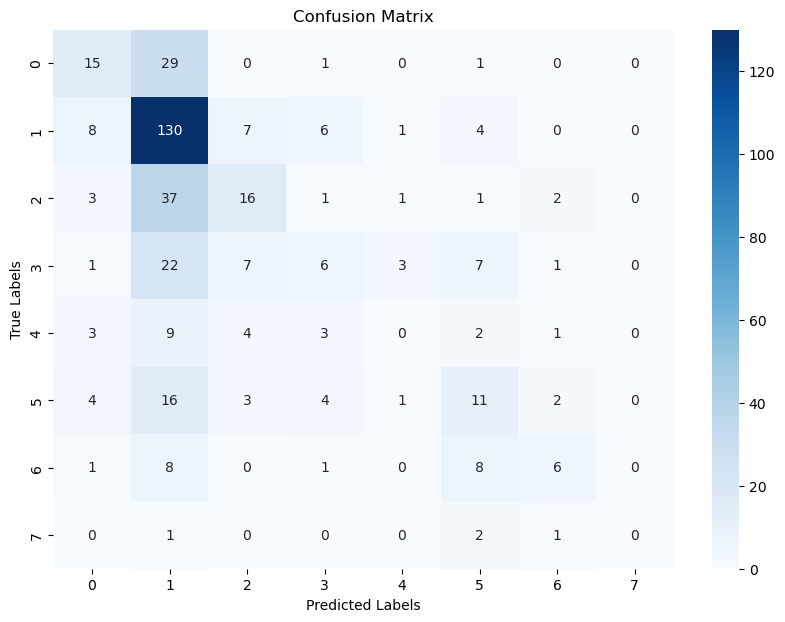

Confusion Matrix:
[[ 15  29   0   1   0   1   0   0]
 [  8 130   7   6   1   4   0   0]
 [  3  37  16   1   1   1   2   0]
 [  1  22   7   6   3   7   1   0]
 [  3   9   4   3   0   2   1   0]
 [  4  16   3   4   1  11   2   0]
 [  1   8   0   1   0   8   6   0]
 [  0   1   0   0   0   2   1   0]]
Accuracy: 0.45885286783042395, Precision: 0.40646318514148944, Recall: 0.45885286783042395, F1 Score: 0.4090751911007629


In [89]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=1)

# Define the parameter grid for RandomForest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Use TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Setup RandomizedSearchCV for the RandomForestClassifier
random_search = RandomizedSearchCV(rf, param_grid, n_iter=10, cv=tscv, scoring='f1_weighted', n_jobs=-1, random_state=1)

# Fit the model
random_search.fit(X_train, y_train)

# Predict on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluation metrics
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Feature importance analysis
feature_importances = best_model.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

print(importance_df)

# Display the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print evaluation metrics
print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")
